In [1031]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import pandas as pd
import statsmodels.api as sm
from IPython.display import display, HTML

from statsmodels.regression.rolling import RollingOLS
from joblib import Parallel, delayed
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from matplotlib.backends.backend_svg import FigureCanvasSVG
from pandas.tseries.offsets import BDay
from sklearn.preprocessing import MinMaxScaler


from functions.utils.system import *
from functions.utils.func import *
from prep_factor import PrepFactor 

import warnings

warnings.filterwarnings('ignore')

In [1032]:
# Params
live = True
stock = read_stock(get_large_dir(live) / 'permno_live.csv')
start = '2005-01-01'
window = 60
threshold = 2_000_000_000
past_date = (date.today() - timedelta(days=1)).strftime('%Y-%m-%d')
current_date = (date.today()).strftime('%Y-%m-%d')
sbo = -0.05
sso = -1.25
sbc = 1.5
ssc = 0.09
format_end = date.today().strftime('%Y%m%d')
trial = f'mrev_{format_end}'
dir_path = Path(get_strategy_mrev() / 'report')

In [1033]:
def create_multi_index(factor_data, stock):
    factor_values = pd.concat([factor_data] * len(stock), ignore_index=True).values
    multi_index = pd.MultiIndex.from_product([stock, factor_data.index])
    multi_index_factor = pd.DataFrame(factor_values, columns=factor_data.columns, index=multi_index)
    multi_index_factor.index = multi_index_factor.index.set_names(['permno', 'date'])
    return multi_index_factor

# CAPM

In [874]:
# Read in ETF data from FMP
T = [1]
spy = get_data_fmp(ticker_list=['SPY'], start=start, current_date=past_date)
spy = spy[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
spy = spy.rename(columns={'Adj Close': 'Close'})

# Create returns and unstack dataframe to only have 'date' index and 'ETF ticker' columns
spy = create_return(spy, T)
spy = spy.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
spy = spy.unstack('ticker').swaplevel(axis=1)
spy.columns = ['_'.join(col).strip() for col in spy.columns.values]
spy = spy.fillna(0)

Fetching data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/ticker]


In [875]:
# Read in price data and set up params for Rolling LR
T = [1]
ret = f'RET_01'
spy_data = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
factor_col_spy = spy.columns
spy_data = create_return(spy_data, T)
spy_data = spy_data.fillna(0)

In [876]:
# Execute Rolling LR
beta_spy = rolling_ols_parallel(data=spy_data, ret=ret, factor_data=spy, factor_cols=factor_col_spy.tolist(), window=window, name=f'spy_01')

In [892]:
beta_spy[beta_spy['SPY_RET_01_spy_01_60'] > 10][['SPY_RET_01_spy_01_60']].index.get_level_values('permno').unique()

Index([14865, 16393, 16532, 51692, 76215, 79444, 84302, 85909, 86083, 89877,
       90288, 92345, 92621, 93126],
      dtype='int64', name='permno')

In [896]:
get_stock_data(beta_spy[beta_spy['SPY_RET_01_spy_01_60'] > 10][['SPY_RET_01_spy_01_60']], 16393)

SPY_RET_01_spy_01_60
permno date                            
16393  2021-01-26             10.514114
       2021-02-03             11.017530
       2021-02-04             10.579369
       2021-02-05             11.188945
       2021-02-08             11.124050
       2021-02-09             11.382733
       2021-02-10             11.561164
       2021-02-11             12.200208
       2021-02-12             12.276539
       2021-02-16             12.169176
       2021-02-17             12.776899
       2021-02-18             12.823061
       2021-02-19             12.940545
       2021-02-22             13.001160
       2021-02-23             14.226149
       2021-02-24             13.579782
       2021-02-25             12.422824
       2021-02-26             12.577433
       2021-03-01             11.355415
       2021-03-02             11.309207
       2021-03-03             11.346973
       2021-03-04             11.894021
       2021-03-05             11.710227
       2021-03-08             11.702266
       2021-03-09             11.435025
       2021-03-10             11.358497
       2021-03-11             11.206122
       2021-03-12             11.159711
       2021-03-15             11.539484
       2021-03-16             11.555497
       2021-03-17             11.620980
       2021-03-18             11.338521
       2021-03-19             11.290601
       2021-03-22             11.013387
       2021-03-23             11.133311
       2021-03-24             11.229490
       2021-03-25             11.383906
       2021-03-26             10.876918
       2021-03-29             10.920230
       2021-03-30             11.014385
       2021-03-31             11.177977
       2021-04-01             11.111301
       2021-04-05             10.736896
       2021-04-06             11.143570
       2021-04-07             11.230288
       2021-04-08             11.299733
       2021-04-09             11.150480
       2021-04-12             11.187357
       2021-04-13             11.232757
       2021-04-14             11.193429
       2021-04-15             10.895019

In [ ]:
tic = pd.read_parquet(get_parquet_dir(live) / 'data_ticker.parquet.brotli')

In [895]:
get_stock_data(tic, 16393)

ticker
permno date             
16393  2016-10-06   OBLN
       2016-10-07   OBLN
       2016-10-10   OBLN
       2016-10-11   OBLN
       2016-10-12   OBLN
...                  ...
       2023-11-01   RSLS
       2023-11-02   RSLS
       2023-11-03   RSLS
       2023-11-06   RSLS
       2023-11-07   RSLS

[1784 rows x 1 columns]

# Past

In [1034]:
# Read in ETF data from FMP
T = [1]
sector_ret_past = get_data_fmp(ticker_list=['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU'], start=start, current_date=past_date)
sector_ret_past = sector_ret_past[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
sector_ret_past = sector_ret_past.rename(columns={'Adj Close': 'Close'})

# Create returns and unstack dataframe to only have 'date' index and 'ETF ticker' columns
sector_ret_past = create_return(sector_ret_past, T)
sector_ret_past = sector_ret_past.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
sector_ret_past = sector_ret_past.unstack('ticker').swaplevel(axis=1)
sector_ret_past.columns = ['_'.join(col).strip() for col in sector_ret_past.columns.values]
sector_ret_past = sector_ret_past.fillna(0)

Fetching data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/ticker]


In [1035]:
# Read in price data and set up params for Rolling LR
T = [1]
ret = f'RET_01'
past_data = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
factor_col_past = sector_ret_past.columns
past_data = create_return(past_data, T)
past_data = past_data.fillna(0)

In [1036]:
# Execute Rolling LR
beta_data_past = rolling_ols_parallel(data=past_data, ret=ret, factor_data=sector_ret_past, factor_cols=factor_col_past.tolist(), window=window, name=f'sector_01')
# Retrieve Needed Data
beta_data_past = beta_data_past[beta_data_past.columns[1:11]]
# Get Xk, Xk Lag, and Xk Diff for OU Process
beta_data_past['Xk'] = beta_data_past[f'epsil_sector_01_{window:02}'].rolling(window).sum()
beta_data_past['Xk_lag'] = beta_data_past['Xk'].groupby('permno').shift(-1)
beta_data_past = beta_data_past.fillna(0)
# Export data
beta_data_past.to_parquet(get_strategy_mrev_data() / 'data_beta_etf.parquet.brotli')

In [1037]:
# Function that executes the OU Regression for historical data (this function will be parallelized)
def per_stock_ou_all(stock_data, ret, factor_col, window, stock_name, index_name):
    model_data = stock_data[[ret, factor_col]].fillna(0)
    exog = sm.add_constant(model_data[factor_col])
    rolling_ols = RollingOLS(endog=model_data[ret], exog=exog, window=window)
    factor_model_params = rolling_ols.fit(params_only=True).params.rename(columns={'const': 'ALPHA'})
    # Calculate predicted values
    predicted = (exog * factor_model_params).sum(axis=1)
    predicted = predicted.rename('pred')

    # Compute residuals (epsilon)
    epsilon = model_data[ret] - predicted
    epsilon = epsilon.rename('epsil')
    result = factor_model_params.join(epsilon).assign(**{index_name: stock_name}).set_index(index_name, append=True).swaplevel()
    return result

# Function to execute the parallelization for historical data
def exec_ou_all(data, ret='Xk', factor_col='Xk_lag', window=window, name='ss'):
    tasks = [(group, ret, factor_col, window, stock, data.index.names[0]) for stock, group in data.groupby(data.index.names[0])]
    results = Parallel(n_jobs=-1)(delayed(per_stock_ou_all)(*task) for task in tasks)
    return pd.concat(results).rename(columns=lambda x: f'{x}_{name}_{window:02}')

In [1038]:
# Execute OU Process
ou_data_past = exec_ou_all(beta_data_past).droplevel(0)
ou_data_past.columns = ['a', 'b', 'e']
# Round the entire DataFrame (this is for inconsistencies in float calculations)
decimal_places = 5
ou_data_past = ou_data_past.round(decimal_places)
# Execute calculations for s-score
ou_data_past['kappa'] = -np.log(ou_data_past['b']) * 252
# Center m on a rolling window basis
ou_data_past['m'] = ou_data_past['a'] / (1 - ou_data_past['b'])
ou_data_past['rolling_mean_m'] = ou_data_past.groupby('permno')['m'].transform(lambda x: x.rolling(window).mean())
ou_data_past['m_centered'] = ou_data_past['m'] - ou_data_past['rolling_mean_m']
# Make sure to groupby 'permno' when calculating variance
ou_data_past['var_e'] = ou_data_past.groupby('permno')['e'].transform(lambda x: x.rolling(window).var())
# Add the calculation of variance of ζ using the provided formula
delta_t = 1/252
ou_data_past['var_zeta'] = ou_data_past['var_e'] * (1 - np.exp(-2 * ou_data_past['kappa'] * delta_t)) / (2 * ou_data_past['kappa'])
ou_data_past['sigma'] = np.sqrt(ou_data_past['var_zeta'] * 2 * ou_data_past['kappa'] / (1 - ou_data_past['b']**2))
ou_data_past['sigma_eq'] = np.sqrt(ou_data_past['var_zeta'] / (1 - ou_data_past['b']**2))
ou_data_past['s_score'] = -ou_data_past['m_centered'] / ou_data_past['sigma_eq']
# Export data
ou_data_past.to_parquet(get_strategy_mrev_data() / 'data_ou_etf.parquet.brotli')

In [1039]:
# # Remove stocks that don't fit the model
# ou_data_past['tau'] = 1 / ou_data_past['kappa']
# filtered_stocks = ou_data_past[ou_data_past['kappa'] > window]
# stocks_to_keep = filtered_stocks.index.unique()  # Get unique identifiers for stocks to keep
# ou_data_filtered = ou_data_past.loc[ou_data_past.index.isin(stocks_to_keep)]

In [1040]:
s_score = get_stock_data(ou_data_past, 93436)[['s_score']]

In [1041]:
s_score.loc[s_score.s_score.isnull()]

s_score
permno date               
93436  2010-06-29      NaN
       2010-06-30      NaN
       2010-07-01      NaN
       2010-07-02      NaN
       2010-07-06      NaN
...                    ...
       2023-08-17      NaN
       2023-08-18      NaN
       2023-08-21      NaN
       2023-08-22      NaN
       2023-08-23      NaN

[235 rows x 1 columns]

<AxesSubplot:xlabel='permno,date'>

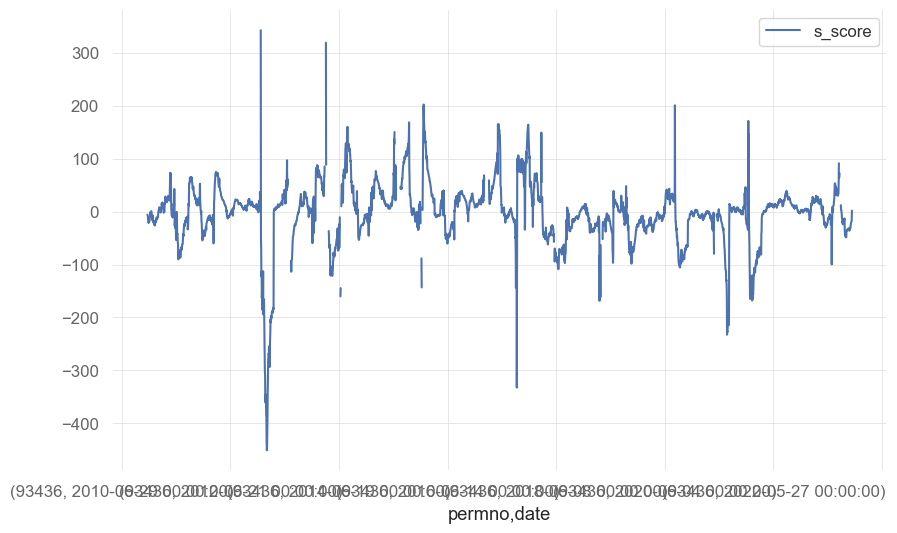

In [1042]:
s_score.plot()

In [1054]:
# Convert ETF Dataframe to multi-index
sector_multi_past = create_multi_index(sector_ret_past, stock)
# Merge the necessary columns together into one dataframe
combined_past = ou_data_past[['s_score', 'kappa']].merge(beta_data_past, left_index=True, right_index=True, how='left')
combined_past = combined_past.merge(sector_multi_past, left_index=True, right_index=True, how='left')
combined_past = combined_past.merge(past_data[['RET_01']], left_index=True, right_index=True, how='left')
combined_past = combined_past.fillna(0)

In [1056]:
# Retrieve the needed columns
combined_past = combined_past[['s_score', 'kappa', 'RET_01',
                     f'XLB_RET_01_sector_01_{window:02}',
                     f'XLE_RET_01_sector_01_{window:02}',
                     f'XLF_RET_01_sector_01_{window:02}',
                     f'XLI_RET_01_sector_01_{window:02}',
                     f'XLK_RET_01_sector_01_{window:02}',
                     f'XLP_RET_01_sector_01_{window:02}',
                     f'XLU_RET_01_sector_01_{window:02}',
                     f'XLV_RET_01_sector_01_{window:02}',
                     f'XLY_RET_01_sector_01_{window:02}',
                     'XLB_RET_01','XLE_RET_01', 'XLF_RET_01', 'XLI_RET_01', 
                     'XLK_RET_01', 'XLP_RET_01', 'XLU_RET_01', 'XLV_RET_01', 'XLY_RET_01']]

In [1057]:
def create_signal_past(data, sbo, sso, sbc, ssc, threshold):
    def apply_rules(group):
        # Initialize signals and positions
        signals = [None] * len(group)
        positions = [None] * len(group)
        # Create masks for conditions
        open_long_condition = (group['s_score'] < -sbo) & (group['market_cap'] > threshold) & (group['kappa'] > 252/(window/2))
        open_short_condition = (group['s_score'] > sso) & (group['market_cap'] > threshold) & (group['kappa'] > 252/(window/2))
        close_long_condition = group['s_score'] > -ssc
        close_short_condition = group['s_score'] < sbc
        # Flag to check if any position is open
        position_open = False
        current_position = None
        
        for i in range(len(group)):
            if position_open:
                if positions[i-1] == 'long' and close_long_condition.iloc[i]:
                    signals[i] = 'close long'
                    positions[i] = None
                    position_open = False
                    current_position = None
                elif positions[i-1] == 'short' and close_short_condition.iloc[i]:
                    signals[i] = 'close short'
                    positions[i] = None
                    position_open = False
                    current_position = None
                else:
                    signals[i] = 'hold'
                    positions[i] = current_position
            else:
                if open_long_condition.iloc[i]:
                    positions[i] = 'long'
                    signals[i] = 'buy to open'
                    current_position = 'long'
                    position_open = True
                elif open_short_condition.iloc[i]:
                    positions[i] = 'short'
                    signals[i] = 'sell to open'
                    position_open = True
                    current_position = 'short'

        return pd.DataFrame({'signal': signals, 'position': positions}, index=group.index)

    # Sort data
    data = data.sort_index(level=['permno', 'date'])
    # Group by permno and apply the rules for each group
    results = data.groupby('permno').apply(apply_rules).reset_index(level=0, drop=True)
    # Flatten the results and assign back to the data
    data = data.join(results)
    return data

In [1058]:
sbo = 1.25
sso = 1.25
sbc = 0.75
ssc = 0.5

# Create signals
copy = combined_past.copy(deep=True)
misc = pd.read_parquet(get_parquet_dir(live) / 'data_misc.parquet.brotli', columns=['market_cap'])
copy = copy.merge(misc, left_index=True, right_index=True, how='left')
result_past = create_signal_past(copy, sbo, sso, sbc, ssc, threshold)
# Shift returns back by 1
result_past['RET_01'] = result_past.groupby('permno')['RET_01'].shift(-1)

In [1059]:
def dis_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display(HTML(html_str.replace('table','table style="display:inline"')))

In [1060]:
dis_side(result_past[['signal']].tail(25), result_past[['position']].tail(25))

In [1061]:
# Calculate strategy's total return per day
def calc_total_ret(df, threshold, etf_returns):
    # Get stock weights
    print("Get stock weights...")
    first_dates_per_year = df.reset_index().groupby(df.index.get_level_values('date').year)['date'].first()
    beta_columns = [col for col in df.columns if '_sector_' in col]
    num_etfs = len(beta_columns)
    stocks_count_dict = {
        date: len(get_stock_idx(set_timeframe(df, str(date.year), str(date.year + 1))))
        for date in first_dates_per_year
    }
    stocks_count_dict = {
        date: len(get_stock_idx(set_timeframe(df, str(date.year), str(date.year + 1)))) + num_etfs
        for date in first_dates_per_year
    }

    df['num_assets'] = df.index.get_level_values('date').map(stocks_count_dict)
    df['num_assets'] = df['num_assets'].ffill()
    df['weight'] = 1 / df['num_assets']

    # Get hedge weights
    print("Get hedge weights...")
    mask_long = df['position'] == 'long'
    mask_short = df['position'] == 'short'
    # df['hedge_weight'] = np.where(mask_long, -1, np.where(mask_short, 1, 0))
    df['hedge_weight'] = np.where(mask_long, -df['weight'], np.where(mask_short, df['weight'], 0))
    
    # Get net hedge betas
    print("Get net hedge betas...")
    weighted_betas = df[beta_columns].multiply(df['hedge_weight'], axis=0)
    net_hedge_betas = weighted_betas.groupby('date').sum()

    # Get net hedge return
    print("Get net hedge return")
    net_hedge_returns = pd.DataFrame(index=net_hedge_betas.index)
    for beta in beta_columns:
        etf_return_column = beta.split('_sector_')[0]
        if etf_return_column in etf_returns.columns:
            net_hedge_returns[beta] = net_hedge_betas[beta] * etf_returns[etf_return_column]
    
    # Get total hedge return
    print("Get total hedge return...")
    net_hedge_return_total = net_hedge_returns.sum(axis=1)
    
    # Get daily return
    print("Get daily return...")
    daily_return = np.where(mask_long, df['RET_01'] * df['weight'], np.where(mask_short, -df['RET_01'] * df['weight'], 0))
    daily_return_series = pd.Series(daily_return, index=df.index)
    daily_return_total = daily_return_series.groupby(level='date').sum()
    
    # Get total portfolio return
    print("Get total portfolio return...")
    total_portfolio_return = daily_return_total + net_hedge_return_total
    return total_portfolio_return, daily_return_total, net_hedge_return_total, net_hedge_betas

In [1062]:
# Calculate strategy's return
ewp_ret, daily, hedge, betas = calc_total_ret(result_past, threshold, sector_ret_past.shift(-1))

Get stock weights...
Get hedge weights...
Get net hedge betas...
Get net hedge return
Get total hedge return...
Get daily return...
Get total portfolio return...


[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-06-22   2005-06-22
End Period                 2023-11-06   2023-11-06
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          258.68%      -37.1%
CAGR﹪                     4.91%        -1.73%

Sharpe                     0.45         -1.58
Prob. Sharpe Ratio         97.37%       0.0%
Smart Sharpe               0.45         -1.55
Sortino                    0.63         -2.08
Smart Sortino              0.63         -2.05
Sortino/√2                 0.45         -1.47
Smart Sortino/√2           0.44         -1.45
Omega                      0.76         0.76

Max Drawdown               -56.47%      -37.12%
Longest DD Days            1982         6707
Volatility (ann.)          19.58%       1.59%
R^2                        0.0          0.0
Information Ratio          -0.04        -0.04
Calmar         

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2005-06-27,2023-11-01,2023-11-06,6707,-37.115793,-36.792243


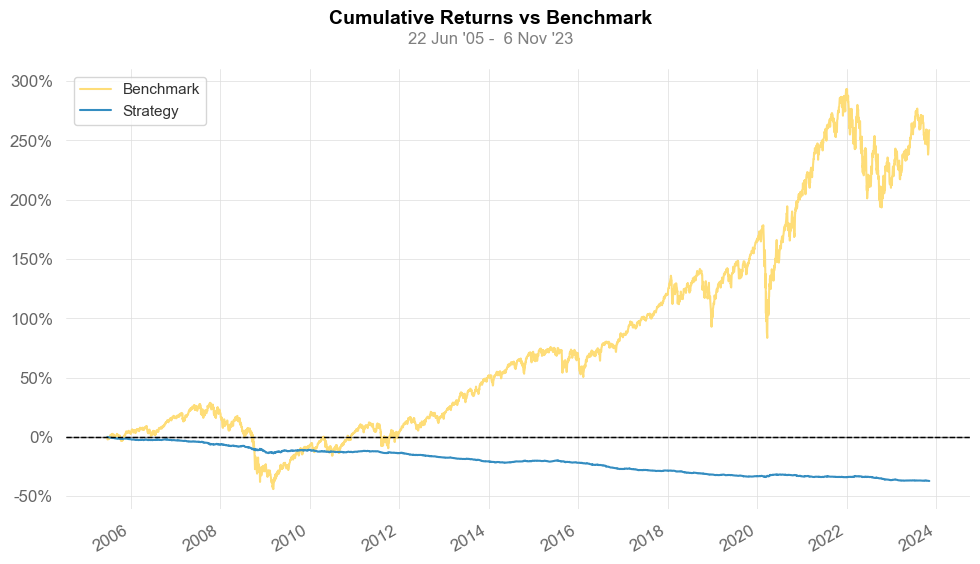

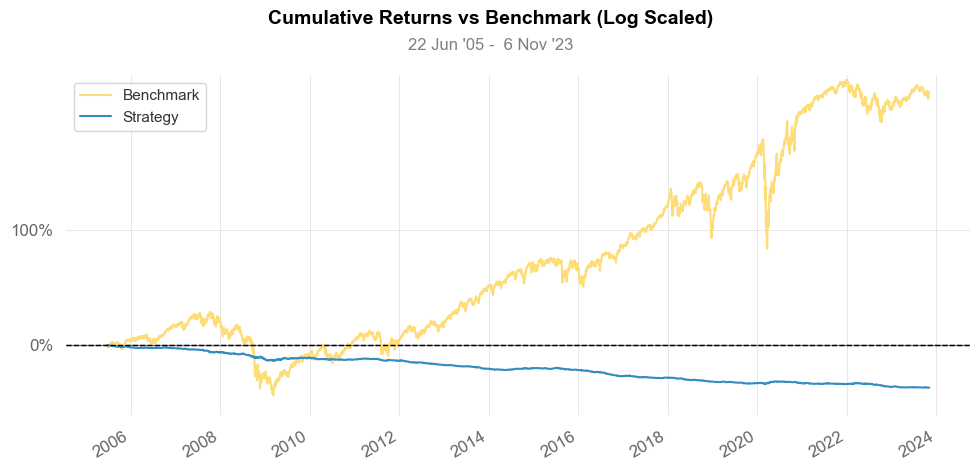

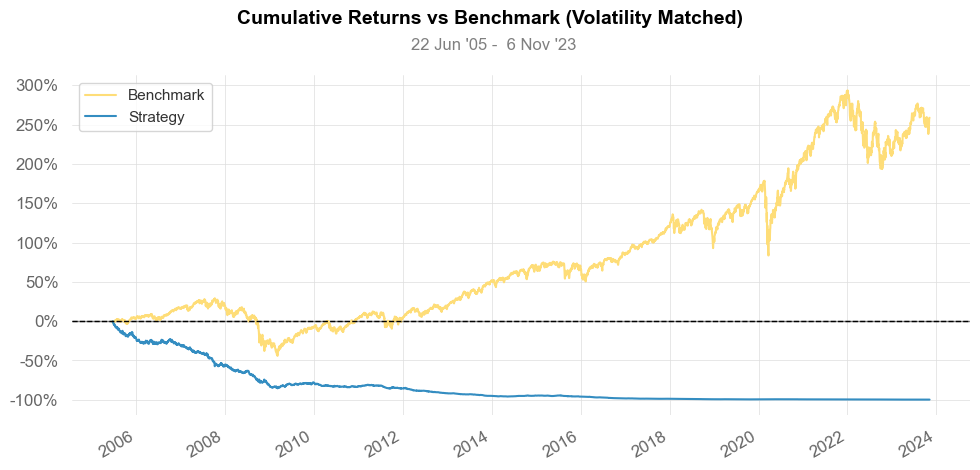

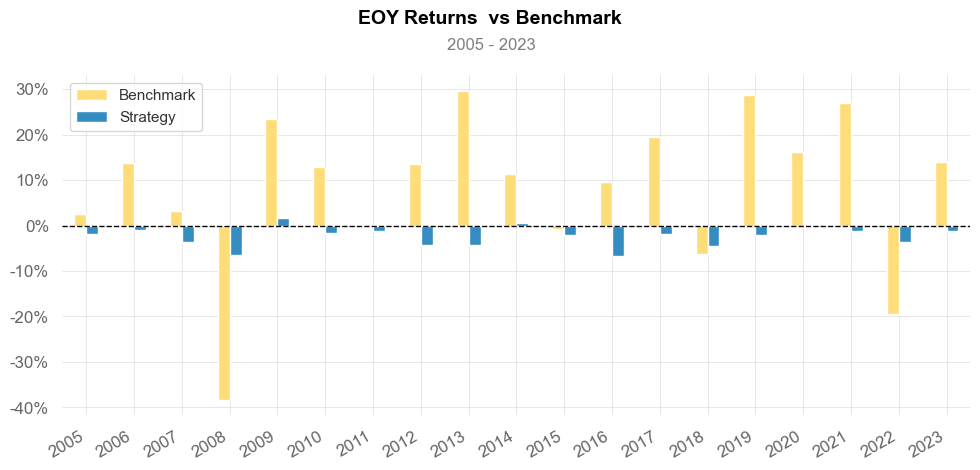

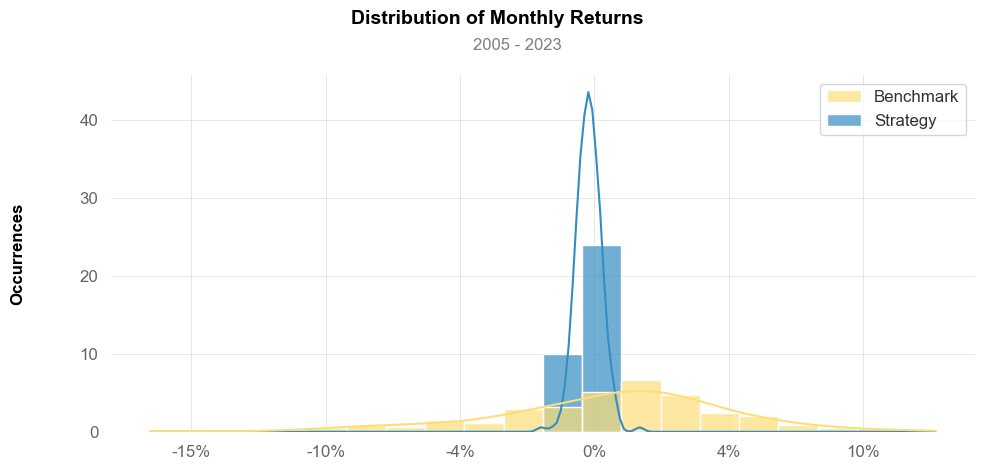

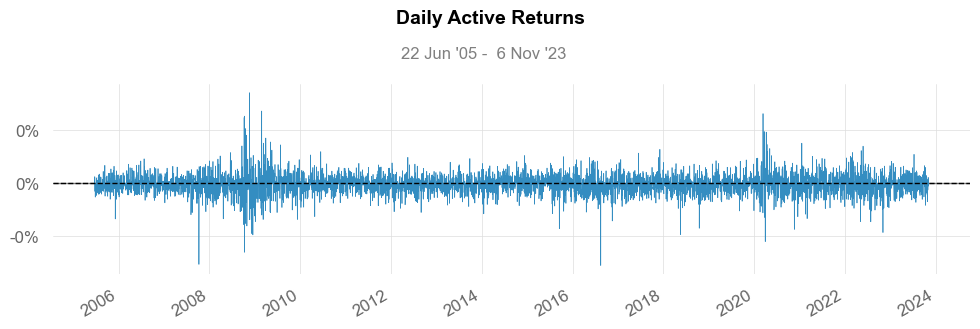

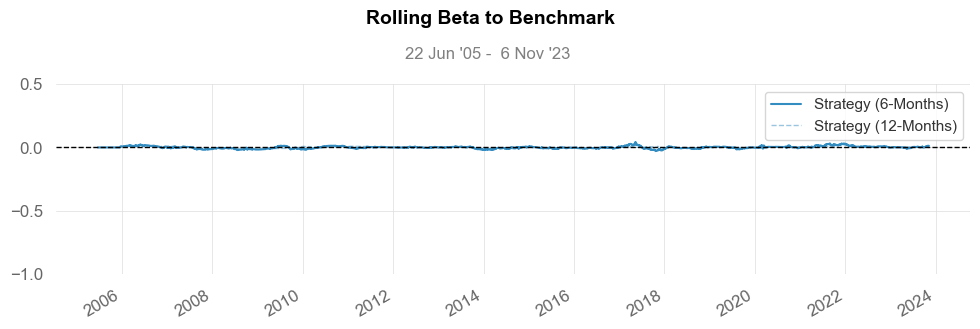

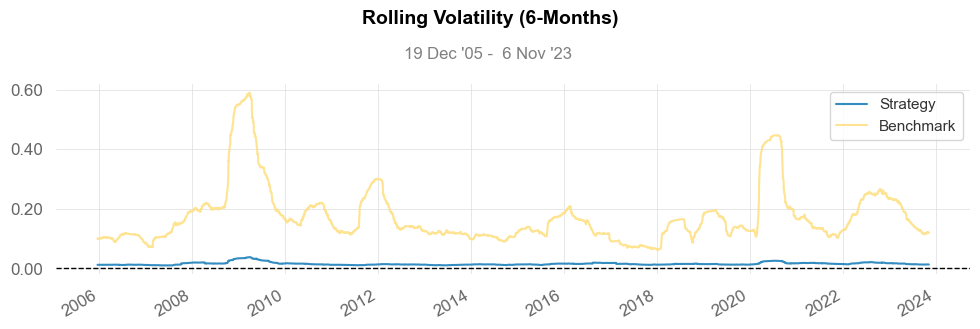

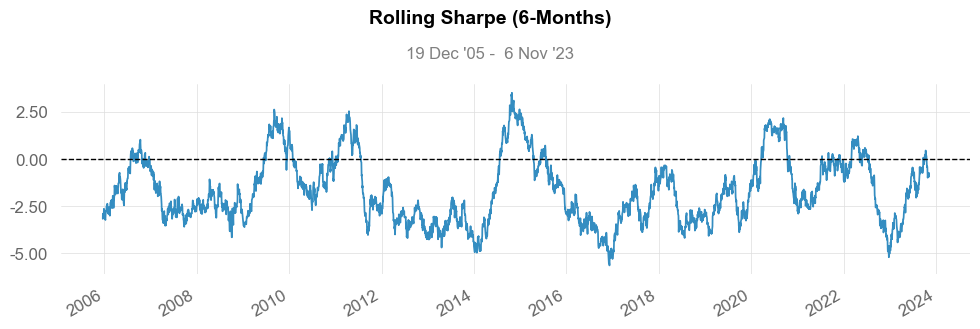

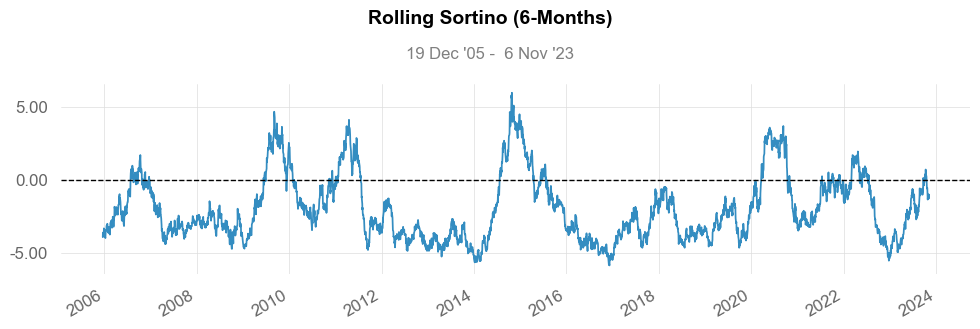

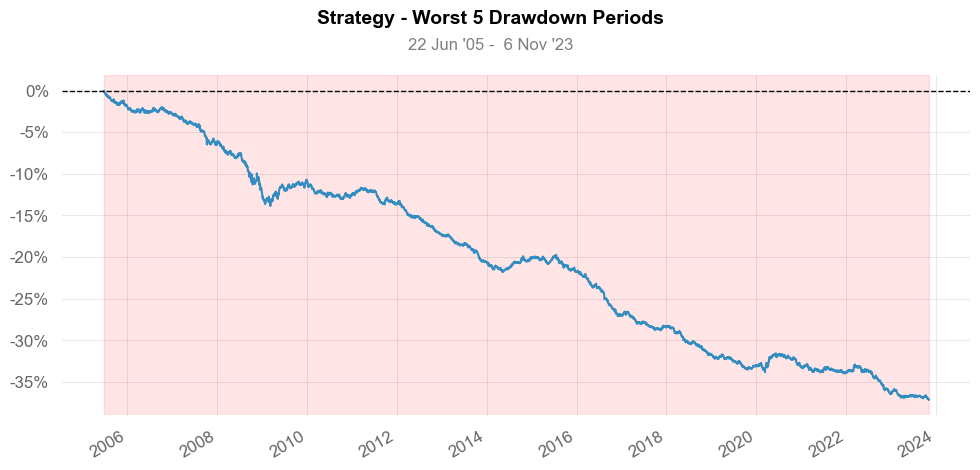

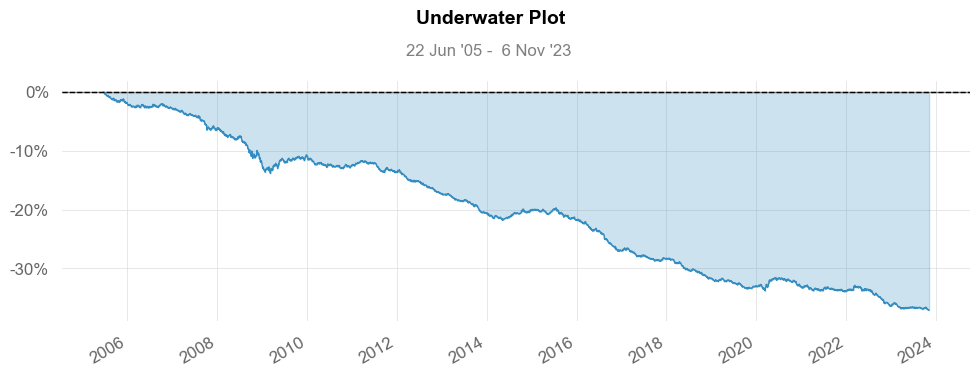

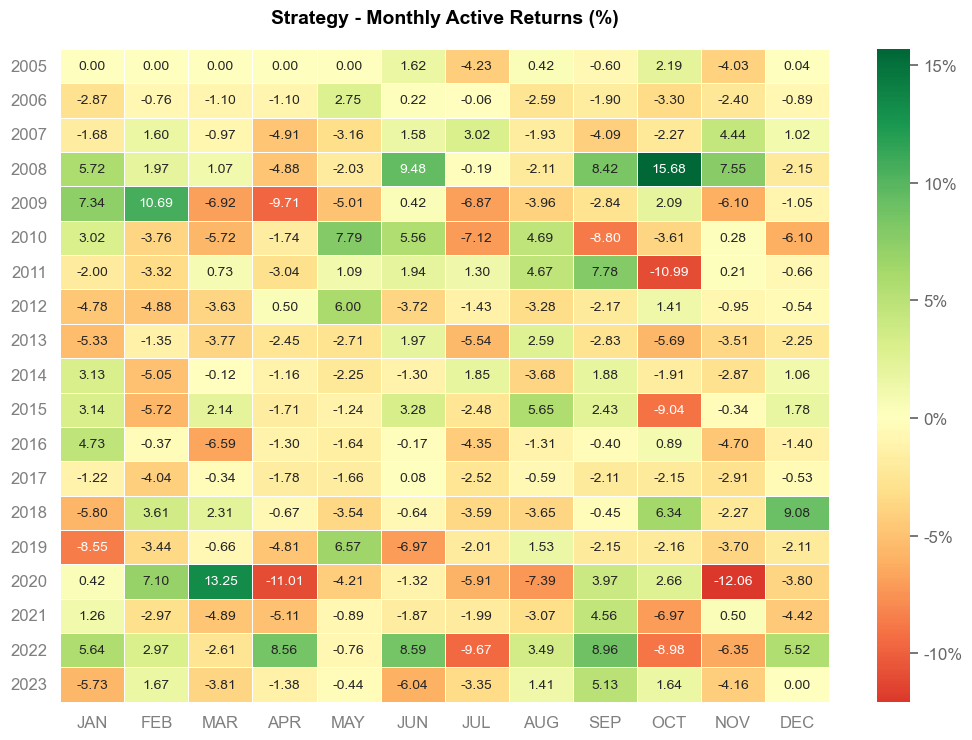

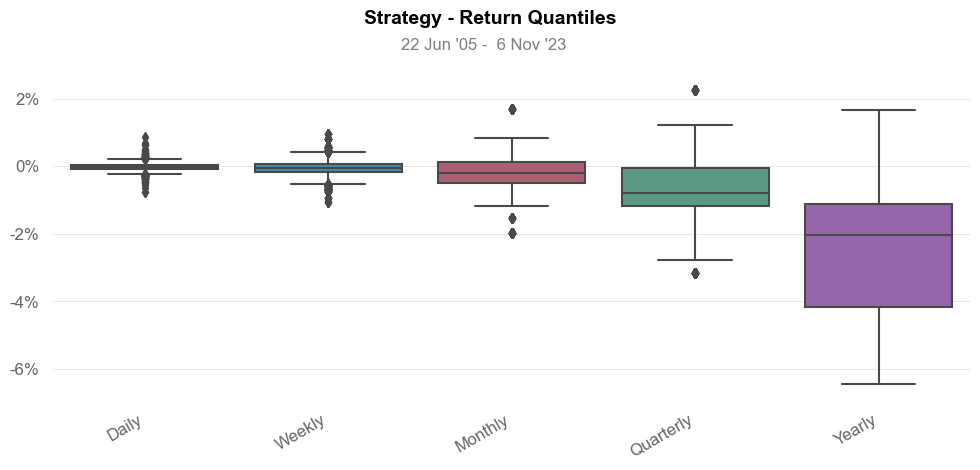

In [1063]:
# Plot Results
spy = get_spy(start_date='2005-01-01', end_date=current_date)
qs.reports.full(ewp_ret, spy, figsize=(10, 5))

In [ ]:
# Export data
result_past[['signal', 'position', 'market_cap', 'num_assets', 'weight', 'hedge_weight']].to_parquet(get_strategy_mrev_data() / 'data_signal_etf.parquet.brotli')

# Live

In [442]:
# Read in ETF data from FMP
T = [1]
sector_ret_live = get_data_fmp(ticker_list=['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU'], start=start, current_date=current_date)
sector_ret_live = sector_ret_live[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
sector_ret_live = sector_ret_live.rename(columns={'Adj Close': 'Close'})

# Create returns and unstack dataframe to only have 'date' index and 'ETF ticker' columns
sector_ret_live = create_return(sector_ret_live, T)
sector_ret_live = sector_ret_live.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
sector_ret_live = sector_ret_live.unstack('ticker').swaplevel(axis=1)
sector_ret_live.columns = ['_'.join(col).strip() for col in sector_ret_live.columns.values]
sector_ret_live = sector_ret_live.fillna(0)

Fetching data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.03ticker/s]


In [443]:
# Read in price data and set up params for Rolling LR
T = [1]
ret = f'RET_01'
live_data = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
factor_col_live = sector_ret_live.columns
live_data = create_return(live_data, T)
live_data = live_data.fillna(0)

In [445]:
# Retrieves 'permno' groups that have data up to current date
def current_data(group):
    recent_dates = group.index.get_level_values('date')
    target_date = pd.to_datetime(current_date) - BDay(window)
    return recent_dates.max() >= target_date and (recent_dates >= target_date).sum() >= window

In [446]:
# Function that executes the RollingOLS for the last window of data (this function will be parallelized)
def per_stock_ols_last(stock_data, ret, factor_data, factor_cols, window, stock_name, index_name):
    # Set up data
    model_data = stock_data[[ret]].merge(factor_data, on='date').dropna()
    model_data = model_data[[ret] + factor_cols]
    model_data = model_data.iloc[-window:]
    # Train model
    exog = sm.add_constant(model_data[factor_cols])
    model = OLS(model_data[ret], exog)
    results = model.fit()
    # Get betas
    factor_model_params = results.params.to_frame().T
    factor_model_params.rename(columns={'const': 'ALPHA'}, inplace=True)
    # Get predictions
    predicted_last = (exog.iloc[-1] * factor_model_params.iloc[-1]).sum()
    predicted_series = pd.Series(predicted_last, name='pred')
    # Compute residuals (epsilon) for the last observation
    epsilon_last = model_data[ret].iloc[-1] - predicted_last
    epsilon_series = pd.Series(epsilon_last, name='epsil')
    # Format data
    result = factor_model_params.assign(epsil=epsilon_series, pred=predicted_series)
    result = result.assign(**{index_name: stock_name}).set_index(index_name, append=True).swaplevel()
    permnos = result.index.get_level_values(0)
    new_index = pd.MultiIndex.from_product([permnos, [pd.to_datetime(current_date)]], names=['permno', 'date'])
    result.index = new_index
    return result

# Function to execute the parallelization for last window of data
def rolling_ols_last(data, ret, factor_data, factor_cols, window, name):
    valid_groups = [(name, group) for name, group in data.groupby(level='permno') if current_data(group)]
    tasks = [(group, ret, factor_data, factor_cols, window, permno, data.index.names[0]) for permno, group in valid_groups]
    results = Parallel(n_jobs=-1)(delayed(per_stock_ols_last)(*task) for task in tasks)
    return pd.concat(results).rename(columns=lambda x: f'{x}_{name}_{window:02}')

In [447]:
# Execute Rolling LR
beta_data_live = rolling_ols_last(data=live_data, ret=ret, factor_data=sector_ret_live, factor_cols=factor_col_live.tolist(), window=window, name=f'sector_01')
beta_data_live = beta_data_live[beta_data_live.columns[1:11]]
# Combine live beta with historical beta
beta_data_past = pd.read_parquet(get_strategy_mrev_data() / 'data_beta_etf.parquet.brotli')
beta_data_live = pd.concat([beta_data_past, beta_data_live], axis=0).sort_index(level=['permno', 'date'])
# Get Xk, Xk Lag, and Xk Diff for OU Process (only for the last window of data)
current_permnos = beta_data_live[beta_data_live.index.get_level_values('date') == pd.to_datetime(current_date)].index.get_level_values('permno').unique()
window_sums = beta_data_live[beta_data_live.index.get_level_values('permno').isin(current_permnos)].groupby('permno')[f'epsil_sector_01_{window:02}'].transform(lambda x: x.tail(window).sum())
last_indices = beta_data_live.loc[(slice(None), current_date), :].index
beta_data_live.loc[last_indices, 'Xk'] = window_sums.loc[last_indices]
beta_data_live['Xk_lag'] = beta_data_live['Xk'].groupby('permno').shift(-1)
beta_data_live['Xk_diff'] = beta_data_live['Xk'].groupby('permno').diff()
beta_data_live = beta_data_live.fillna(0)
# Update Data
# beta_data_live.to_parquet(get_strategy_mrev_data() / 'data_beta_etf.parquet.brotli')

In [450]:
# Function that executes the OU Regression for last window of data (this function will be parallelized)
def per_stock_ou_last(stock_data, ret, factor_col, window, stock_name, index_name):
    # Get Data
    model_data = stock_data.iloc[-window:].fillna(0)
    exog = sm.add_constant(model_data[factor_col])
    # Train model
    model = OLS(model_data[ret], exog)
    results = model.fit()
    # Get betas
    factor_model_params = results.params.to_frame().T
    factor_model_params.rename(columns={'const': 'ALPHA'}, inplace=True)
    # Format data
    result = factor_model_params
    result = result.assign(**{index_name: stock_name}).set_index(index_name, append=True).swaplevel()
    permnos = result.index.get_level_values(0)
    new_index = pd.MultiIndex.from_product([permnos, [pd.to_datetime(current_date)]], names=['permno', 'date'])
    result.index = new_index
    return result

# Function to execute the parallelization for last window of data
def exec_ou_last(data, ret='Xk_diff', factor_col='Xk_lag', window=window, name='ss'):
    valid_groups = [(name, group) for name, group in data.groupby(level='permno') if current_data(group)]
    tasks = [(group, ret, factor_col, window, permno, data.index.names[0]) for permno, group in valid_groups]
    results = Parallel(n_jobs=-1)(delayed(per_stock_ou_last)(*task) for task in tasks)
    return pd.concat(results).rename(columns=lambda x: f'{x}_{name}_{window:02}')

In [451]:
# Read in historical OU Process Data
ou_data_past = pd.read_parquet(get_strategy_mrev_data() / 'data_ou_etf.parquet.brotli')
# Execute OU Process
ou_data_live = exec_ou_last(beta_data_live)
ou_data_live.columns = ['a', 'b']
ou_data_live = ou_data_live.merge(beta_data_live[['Xk_diff', 'Xk_lag']], left_index=True, right_index=True, how='right')
ou_data_live = ou_data_live.sort_index(level=['permno', 'date'])
# Round the entire DataFrame (this is for inconsistencies in float calculations)
decimal_places = 5
ou_data_live = ou_data_live.round(decimal_places)
# Execute calculations for s-score
ou_data_live['kappa'] = -np.log(ou_data_live['b']) * 252
ou_data_live['m'] = ou_data_live['a'] / (1 - ou_data_live['b'])
# Create a new dataframe to calculate variance across historical data up to current date
variance_concat = pd.concat([ou_data_past, ou_data_live], axis=0).sort_index(level=['permno', 'date'])
# Make sure to groupby 'permno' when calculating variance
variance_concat['var_Xk_diff'] = variance_concat.groupby('permno')['Xk_diff'].transform('var')
ou_data_live = ou_data_live.merge(variance_concat[['var_Xk_diff']], left_index=True, right_index=True, how='left')
ou_data_live['sigma'] = np.sqrt(ou_data_live['var_Xk_diff'] * 2 * ou_data_live['kappa'] / (1 - ou_data_live['b']**2))
ou_data_live['sigma_eq'] = np.sqrt(ou_data_live['var_Xk_diff'] / (1 - ou_data_live['b']**2))
ou_data_live['s_score'] = -ou_data_live['m'] / ou_data_live['sigma_eq']
ou_data_live = ou_data_live.loc[ou_data_live.index.get_level_values('date')==current_date]
# Add the end of past OU dataset
ou_data_live = pd.concat([ou_data_past, ou_data_live], axis=0).sort_index(level=['permno', 'date'])
# Update Data
# ou_data_live.to_parquet(get_strategy_mrev_data() / 'data_ou_etf.parquet.brotli')

In [453]:
# Convert ETF Dataframe to multi-index
sector_multi_live = create_multi_index(sector_ret_live, stock)
# Merge the necessary columns together into one dataframe
combined_live = ou_data_live[['s_score']].merge(beta_data_live, left_index=True, right_index=True, how='left')
combined_live = combined_live.merge(sector_multi_live, left_index=True, right_index=True, how='left')
combined_live = combined_live.merge(live_data[['RET_01']], left_index=True, right_index=True, how='left')
signal_past = pd.read_parquet(get_strategy_mrev_data() / 'data_signal_etf.parquet.brotli')
combined_live = combined_live.merge(signal_past[['signal', 'position']], left_index=True, right_index=True, how='left')
combined_live = combined_live.fillna(0)

In [454]:
# Retrieve necessary columns
combined_live = combined_live[['s_score', 'signal', 'position', 'RET_01',
                     f'XLB_RET_01_sector_01_{window:02}',
                     f'XLE_RET_01_sector_01_{window:02}',
                     f'XLF_RET_01_sector_01_{window:02}',
                     f'XLI_RET_01_sector_01_{window:02}',
                     f'XLK_RET_01_sector_01_{window:02}',
                     f'XLP_RET_01_sector_01_{window:02}',
                     f'XLU_RET_01_sector_01_{window:02}',
                     f'XLV_RET_01_sector_01_{window:02}',
                     f'XLY_RET_01_sector_01_{window:02}',
                     'XLB_RET_01','XLE_RET_01', 'XLF_RET_01', 'XLI_RET_01', 
                     'XLK_RET_01', 'XLP_RET_01', 'XLU_RET_01', 'XLV_RET_01', 'XLY_RET_01']]

In [460]:
# Create signals for current date data
def create_signal_live(data, sbo, sso, sbc, ssc, threshold):
    def apply_rules(group):
        if current_date in group.index.get_level_values('date'):
            # Retrieve the current date's s_score and market_cap
            current_s_score = group.iloc[-1]['s_score']
            market_cap = group.iloc[-1]['market_cap']
            # Retrieve the previous date's position
            prev_date_position = group.iloc[-2]['position']
            # Set conditions for signals and positions
            if prev_date_position == 'long':
                if current_s_score > -ssc:
                    signal = 'close long'
                    position = None
                else:
                    signal = 'hold'
                    position = 'long'
            elif prev_date_position == 'short':
                if current_s_score < sbc:
                    signal = 'close short'
                    position = None
                else:
                    signal = 'hold'
                    position = 'short'
            elif prev_date_position == None:
                if current_s_score < -sbo and market_cap > threshold:
                    signal = 'buy to open'
                    position = 'long'
                elif current_s_score > sso and market_cap > threshold:
                    signal = 'sell to open'
                    position = 'short'
            else:
                signal = None
                position = None
            return pd.Series({'signal': signal, 'position': position})
        
    # Apply the rules to each permno group and get signals and positions for the current date
    signal_positions = data.groupby(level='permno').apply(apply_rules)

    # Assign the new signals and positions to the data for the current date
    for permno in signal_positions.index:
        if pd.notna(signal_positions.loc[permno, 'signal']):
            data.loc[(permno, current_date), 'signal'] = signal_positions.loc[permno, 'signal']
            data.loc[(permno, current_date), 'position'] = signal_positions.loc[permno, 'position']
    return data

In [461]:
# Create signals
copy = combined_live.copy(deep=True)
misc = pd.read_parquet(get_parquet_dir(live) / 'data_misc.parquet.brotli', columns=['market_cap'])
copy = copy.merge(misc, left_index=True, right_index=True, how='left')
result_live = create_signal_live(copy, sbo, sso, sbc, ssc, threshold)
result_live['RET_01'] = result_live.groupby('permno')['RET_01'].shift(-1)

In [467]:
# Update weights for current date
def update_weight(df):
    # Get stock weights for the current date
    print("Update stock weights for the current date...")
    beta_columns = [col for col in df.columns if '_sector_' in col]
    num_etfs = len(beta_columns)
    stock_idx = get_stock_idx(set_timeframe(df, str(pd.to_datetime(current_date).year), str(pd.to_datetime(current_date).year + 1)))
    num_assets = len(stock_idx) + num_etfs

    # Update num_assets and weight for the current date only
    print("Update num_assets and weight for the current date only...")
    df.loc[(slice(None), current_date), 'num_assets'] = num_assets
    df.loc[(slice(None), current_date), 'weight'] = 1 / num_assets

    # Update hedge_weight for the current date only
    print("Update hedge weights for the current date...")
    mask_long = (df.loc[(slice(None), current_date), 'position'] == 'long')
    mask_short = (df.loc[(slice(None), current_date), 'position'] == 'short')
    df.loc[(slice(None), current_date), 'hedge_weight'] = np.where(
        mask_long, -df.loc[(slice(None), current_date), 'weight'],
        np.where(mask_short, df.loc[(slice(None), current_date), 'weight'], 0)
    )
    return df

In [468]:
# Read in historical signal dataframe
signal_past = pd.read_parquet(get_strategy_mrev_data() / 'data_signal_etf.parquet.brotli', columns=['num_assets', 'weight', 'hedge_weight'])
result_live = result_live.merge(signal_past, left_index=True, right_index=True, how='left')
# Update weight for dataframe
result_live = update_weight(result_live)

Update stock weights for the current date...
Update hedge weights for the current date...


In [149]:
result_live[['signal', 'position', 'market_cap', 'num_assets', 'weight', 'hedge_weight']].to_parquet(get_strategy_mrev_data() / 'data_signal_etf.parquet.brotli')

In [150]:
# Calculate strategy's return
ewp_ret = calc_total_ret(result_live, threshold, sector_ret_live.shift(-1))

In [152]:
# Export QS report
spy = get_spy(start_date='2005-01-01', end_date=current_date)
qs.reports.html(ewp_ret, spy, output=dir_path / f'{trial}.html')

[*********************100%%**********************]  1 of 1 completed


# Get Positions

In [482]:
# Get current date dataframe
trade = result_live.loc[result_live.index.get_level_values('date') == current_date]
trade = trade.fillna(0)

In [492]:
# Get weight to invest into each ETF for current date
beta_columns = [col for col in trade.columns if '_sector_' in col]
weighted_betas = trade[beta_columns].multiply(trade['hedge_weight'], axis=0)
net_hedge_betas = weighted_betas.groupby('date').sum()
net_hedge_betas.columns = [(col.split('_')[0]) for col in beta_columns]

In [256]:
# Read in ticker dataframe
ticker = pd.read_parquet(get_parquet_dir(live) / 'data_ticker.parquet.brotli')

In [494]:
# Get long positions
long = trade.loc[trade['signal'].str.contains('buy', na=False)]
long = long.merge(ticker, left_index=True, right_index=True, how='left')
long_ticker = list(zip(long['ticker'], long['weight']))

In [495]:
# Get short positions
short = trade.loc[trade['signal'].str.contains('short', na=False)]
short = short.merge(ticker, left_index=True, right_index=True, how='left')
short_ticker = list(zip(short['ticker'], short['weight']))

In [497]:
def display_stock(stocks, title):
    n = len(stocks)
    cols = int(math.sqrt(2 * n))
    max_length = max([len(item[0]) for item in stocks])

    text_content = f"{title}\n"
    border_line = '+' + '-' * (max_length + 3) * cols + '+\n'

    text_content += border_line
    for i in range(n):
        text_content += f"| {stocks[i][0].center(max_length)} "
        if (i + 1) % cols == 0:
            text_content += "|\n"
            text_content += border_line
    return text_content

In [ ]:
# Display stocks to long and short tomorrow
content = display_stock(long_ticker, "Stocks to Long Today:")
content += '\n\n' + display_stock(short_ticker, "Stocks to Short Today:")
print(content)

# Append long/short stocks to dataframe and export
all_columns = ['date'] + [f'Long_{i:02}' for i in range(1, len(long) + 1)] + [f'Short_{i:02}' for i in range(1, len(short) + 1)]
stock_data = [current_date] + long_ticker + short_ticker
df_combined_stock = pd.DataFrame([stock_data], columns=all_columns)
filename_stock = Path(get_strategy_mrev() / f'trade_stock_mrev.csv')

etf_columns = ['date'] + [f'ETF_{i:02}' for i in range(1, len(etf_ticker) + 1)]
etf_data = [current_date] + etf_ticker
df_combined_etf = pd.DataFrame([etf_data], columns=etf_columns)
filename_etf = Path(get_strategy_mrev() / f'trade_etf_mrev.csv')

def update_csv_for_date(filename, df_combined, current_date):
    # Check if file exists
    if os.path.exists(filename):
        existing_df = pd.read_csv(filename)
        # Check if the current_date already exists in the existing_df
        if current_date in existing_df['date'].values:
            existing_df = existing_df[existing_df['date'] != current_date]
        updated_df = pd.concat([existing_df, df_combined], ignore_index=True)
        updated_df.to_csv(filename, index=False)
    else:
        df_combined.to_csv(filename, index=False)

# Assuming df_combined_stock and df_combined_etf are your dataframes for stock and ETF respectively
# and filename_stock and filename_etf are the corresponding filenames for stock and ETF data
update_csv_for_date(filename_stock, df_combined_stock, current_date)
update_csv_for_date(filename_etf, df_combined_etf, current_date)